<a href="https://colab.research.google.com/github/mining-software-repositories/treinamento/blob/main/handson2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

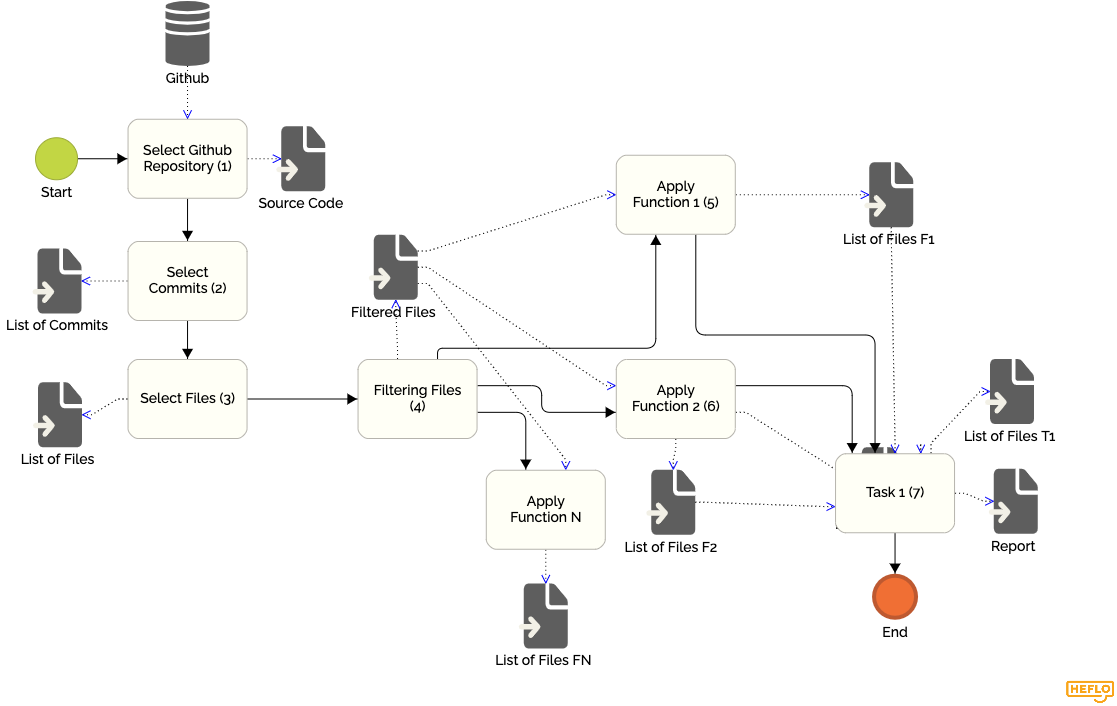

# Set Environment

## Install modules

In [ ]:
# Instala modulos que serão usados
# https://pydriller.readthedocs.io/en/latest/
!pip install pydriller

## Install OS packages

In [ ]:
#For google colab
!sudo apt install tree

## Imports

In [3]:
from pydriller import Repository
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go

# 1. Select Github repository



In [ ]:
!git clone https://github.com/armandossrecife/promocity.git

In [ ]:
!git clone https://github.com/armandossrecife/syspromocity.git

In [ ]:
# Clona o repositorio treinamento para acessar as libs proprietárias
!git clone https://github.com/mining-software-repositories/treinamento.git

In [7]:
# Define uma variável para representar os repositórios que serão trabalhados
repositorio1 = "promocity"
repositorio2 = 'syspromocity'

# Fuctions

In [9]:
def get_list_of_files_and_directories_updated(repositorio):
  list_of_files_and_directories = !cd {repositorio} && tree -i -f
  temp = f'{repositorio}/'
  result = [each.replace('./', temp) for each in list_of_files_and_directories]
  return result

In [10]:
def get_list_of_files_and_directories_src(repositorio, folder_src='src', folder_java='src/main/java/'):
  # Escolhe o diretorio do source java
  # Lista apenas arquivos e diretorios do src/main/java
  result = []

  for item in get_list_of_files_and_directories_updated(repositorio):
    if folder_src in item:
      if folder_java in item:
        result.append(item)
  return result

In [11]:
def get_list_locs_of_files(repositorio):
  # Cria um arquivo contendo a quantidade de LOC por arquivo
  !find {repositorio} -name *.java | xargs wc -l > locarquivosjava.txt
  list_locs_of_files = !cat locarquivosjava.txt

  # Cria uma lista com elementos que representam o LOC e o arquivo
  # (Loc, arquivo)
  result = []
  for each in list_locs_of_files:
    elementos = each.split(' ') 
    item = elementos[-2], elementos[-1]
    result.append(item)
  return result

In [12]:
def get_dict_java_frequency_commits(dict_frequency_files_commits):
  dict_java_frequency_commits = {}
  for file, frequency in dict_frequency_files_commits.items():
    if '.java' in file:
      dict_java_frequency_commits[file] = frequency
  return dict_java_frequency_commits

In [13]:
def get_dict_java_lines_modified(dict_lines_modified_in_files):
  dict_java_lines_modified = {}
  for file, lines_modified in dict_lines_modified_in_files.items():
    if '.java' in file:
      dict_java_lines_modified[file] = lines_modified
  return dict_java_lines_modified

In [14]:
def convert_dict_java_frequency_to_dataframe(dict_java_frequency_commits):
  # Converte o dicionário dict_java_frequency_commits em um dataframe
  df_java_frequency_commits = pd.DataFrame(dict_java_frequency_commits.items(), columns=['File', 'Frequency'])
  return df_java_frequency_commits

In [15]:
def convert_dict_java_lines_modified_to_dataframe(dict_java_lines_modified):
  # Converte o dicionário dict_java_lines_modified em um dataframe
  df_java_lines_modified = pd.DataFrame(dict_java_lines_modified.items(), columns=['File', 'lines_modified'])
  return df_java_lines_modified

In [16]:
def merge_dataframes_java_frequency(df_java_frequency_commits, df_java_lines_modified):
  # Faz o merge das informações para criar um dataframe contendo o arquivo, 
  # a frequência de Commits e Linhas Modificadas de cada arquivo ao longo do tempo
  df = df_java_frequency_commits[['File', 'Frequency']]
  df['lines_modified'] = df_java_lines_modified['lines_modified']
  return df

In [17]:
def generate_sccater_plot(df_fc_ml, repositorio=None):
  plt.style.use('ggplot')
  plt.figure(figsize=(12,8))
  sns.scatterplot(data=df_fc_ml, x='lines_modified', y='Frequency')

  titulo_temp = f'{repositorio} - LoCs Modifications x Files Occurrence in Commits'
  abbr={'titulo':titulo_temp, 'lines_modified':'LoCs Modifications', 'Frequency':'Files Occurrence in Commits'}

  plt.title(f"Analysis of {repositorio} Repository : {abbr['lines_modified']} x {abbr['Frequency']}")
  plt.xlabel(abbr['lines_modified'])
  plt.ylabel(abbr['Frequency'])
          
  for i in range(df_fc_ml.shape[0]): 
    plt.text(df_fc_ml.lines_modified[i], y=df_fc_ml.Frequency[i], s=df_fc_ml.File[i], alpha=0.8, fontsize=8)

  plt.show()

In [18]:
def generate_sccater_plot_2(df_fc_ml, repositorio=None):
  # array de complexidade ciclomatica
  array_cc = np.random.randint(1, 300, size=300)
  # Add traces
  fig = go.Figure(data=go.Scatter(
                      x=df_fc_ml.lines_modified, 
                      y=df_fc_ml.Frequency,
                      mode='markers',
                      name='markers',
                      customdata=df_fc_ml.File,
                      hovertext=df_fc_ml.File, 
                      marker=dict(size=8, color=array_cc, colorscale='Blues', showscale=True, colorbar={"title": 'CC'})
                      )
                    )
  
  titulo_temp = f'{repositorio} - LoCs Modifications x Files Occurrence in Commits'

  fig.update_layout({"title_text": titulo_temp},     
                    width=1000,
                    height=600
                    )
  fig.update_xaxes(
          title_text = "LoC Modifications",
          title_font = {"size": 10}
          )
  fig.update_yaxes(
          title_text = "Commit Frequency",
          title_font = {"size": 10}
          )

  fig.show()

In [19]:
def generate_box_plot_frequency(df_fc_ml):
  s_boxplot_fc = df_fc_ml['Frequency']
  df_boxplot_fc = s_boxplot_fc.to_frame(name='Frequency')
  df_boxplot_fc['File'] = 'File'
  plt.figure(figsize=(6,4))
  sns.boxplot(x='File', y='Frequency', data=df_boxplot_fc)
  return df_boxplot_fc

In [20]:
def get_quartiles_frequency(df_boxplot_fc):
  fc_q1 = np.percentile(df_boxplot_fc.Frequency , [25])
  fc_q2 = np.percentile(df_boxplot_fc.Frequency , [50])
  fc_q3 = np.percentile(df_boxplot_fc.Frequency , [75])
  fc_q4 = np.percentile(df_boxplot_fc.Frequency , [100])
  return fc_q1, fc_q2, fc_q3, fc_q4

In [21]:
def generate_box_plot_lines_modified(df_fc_ml):
  s_boxplot_lm = df_fc_ml['lines_modified']
  df_boxplot_lm = s_boxplot_lm.to_frame(name='lines_modified')
  df_boxplot_lm['File'] = 'File'
  df_boxplot_lm
  plt.figure(figsize=(6,4))
  # Constroi o Boxsplot excluindo arquivos que apareceram em menos de 10 commits
  sns.boxplot(x='File', y='lines_modified', data=df_boxplot_lm)
  return df_boxplot_lm

In [22]:
def get_quartiles_lines_modified(df_boxplot_lm):
  lm_q1 = np.percentile(df_boxplot_lm.lines_modified , [25])
  lm_q2 = np.percentile(df_boxplot_lm.lines_modified , [50])
  lm_q3 = np.percentile(df_boxplot_lm.lines_modified , [75])
  lm_q4 = np.percentile(df_boxplot_lm.lines_modified , [100])
  return lm_q1, lm_q2, lm_q3, lm_q4

# Directory and File Analyzer

In [23]:
# Substitui o . pelo repositorio/
list_of_files_and_directories = get_list_of_files_and_directories_updated(repositorio1)
list_of_files_and_directories_2 = get_list_of_files_and_directories_updated(repositorio2)

In [24]:
# Escolhe o diretorio do source java
# Lista apenas arquivos e diretorios do src/main/java
list_of_files_and_directories_src = get_list_of_files_and_directories_src(repositorio1)
list_of_files_and_directories_src_2 = get_list_of_files_and_directories_src(repositorio2)

In [25]:
# Cria um arquivo contendo a quantidade de LOC por arquivo
list_locs_of_files_updated = get_list_locs_of_files(repositorio1)
list_locs_of_files_updated_2 = get_list_locs_of_files(repositorio2)

# Commits and Files Analyzer

In [26]:
# Importa funcoes pre-definidas para manipular repositorios usando o Pydriller
import treinamento.utils.msr as msr

## 2. Select commits

In [27]:
# Lista todos os commits de um repositorio
list_commits_promocity = msr.list_all_commits(repositorio1)
list_commits_syspromocity = msr.list_all_commits(repositorio2)

## 3. Select files from commits

In [28]:
# Lista todos os arquivos modificados em cada commit
dict_modified_files_promocity = msr.list_all_modified_files_in_commits(repositorio1)
dict_modified_files_syspromocity = msr.list_all_modified_files_in_commits(repositorio2)

In [ ]:
# Lista todos os commits e seus arquivos modificados
for commit, lista_files in dict_modified_files_promocity.items(): 
  print(commit, [file.filename for file in lista_files])

In [ ]:
# Lista todos os commits e seus arquivos modificados
for commit, lista_files in dict_modified_files_syspromocity.items(): 
  print(commit, [file.filename for file in lista_files])

In [33]:
# 5. Lista a frequência dos arquivos nos commits
dict_frequency_files_commits = msr.get_files_frequency_in_commits(repositorio1)
dict_frequency_files_commits_2 = msr.get_files_frequency_in_commits(repositorio2)

In [34]:
# 6. Lista a Quantidade de Linhas de Código Modificadas em cada Arquivo
dict_lines_modified_in_files = msr.get_number_of_lines_of_code_changes_in_commits(repositorio1)
dict_lines_modified_in_files_2 = msr.get_number_of_lines_of_code_changes_in_commits(repositorio2)

## 4. Select only java files


In [35]:
dict_java_frequency_commits = get_dict_java_frequency_commits(dict_frequency_files_commits)
dict_java_frequency_commits_2 = get_dict_java_frequency_commits(dict_frequency_files_commits_2)

In [39]:
dict_java_lines_modified = get_dict_java_lines_modified(dict_lines_modified_in_files)
dict_java_lines_modified_2 = get_dict_java_lines_modified(dict_lines_modified_in_files_2)

# 7. Task Analyzer

Faz a análise entre Frequência de Commits dos Arquivos e Linhas Modificadas de cada arquivo ao longo do tempo

In [42]:
# Converte o dicionário dict_java_frequency_commits em um dataframe
df_java_frequency_commits = convert_dict_java_frequency_to_dataframe(dict_java_frequency_commits)
df_java_frequency_commits_2 = convert_dict_java_frequency_to_dataframe(dict_java_frequency_commits_2)

In [43]:
# Converte o dicionário dict_java_lines_modified em um dataframe
df_java_lines_modified = convert_dict_java_lines_modified_to_dataframe(dict_java_lines_modified)
df_java_lines_modified_2 = convert_dict_java_lines_modified_to_dataframe(dict_java_lines_modified_2)

## Promocity

In [44]:
# Faz o merge das informações para criar um dataframe contendo o arquivo, a frequência de Commits e Linhas Modificadas de cada arquivo ao longo do tempo
df_fc_ml = merge_dataframes_java_frequency(df_java_frequency_commits, df_java_lines_modified)
df_fc_ml

,File,Frequency,lines_modified
0,BackendApplication.java,2,23
1,GenericExceptionMapper.java,1,20
2,JerseyConfiguration.java,6,54
3,UserLocationMonitoring.java,11,316
4,BookController.java,1,100
...,...,...,...
60,TrackService.java,1,31
61,ManipuladorDatas.java,1,27
62,ReportStore.java,1,129
63,ReportUser.java,1,136


## SysPromocity

In [45]:
# Faz o merge das informações para criar um dataframe contendo o arquivo, a frequência de Commits e Linhas Modificadas de cada arquivo ao longo do tempo
df_fc_ml_2 = merge_dataframes_java_frequency(df_java_frequency_commits_2, df_java_lines_modified_2)
df_fc_ml_2

,File,Frequency,lines_modified
0,MvcConfig.java,1,21
1,SystemApplication.java,2,26
2,AccessControlController.java,4,151
3,CouponController.java,3,189
4,CustomerController.java,1,85
5,DashboardController.java,7,300
6,PromotionController.java,9,486
7,StoreController.java,10,722
8,UserController.java,13,636
9,AbstractModel.java,2,55


# Results

## Scatter plot Linhas Modificadas x Frequencia dos Arquivos nos Commits

### Promocity

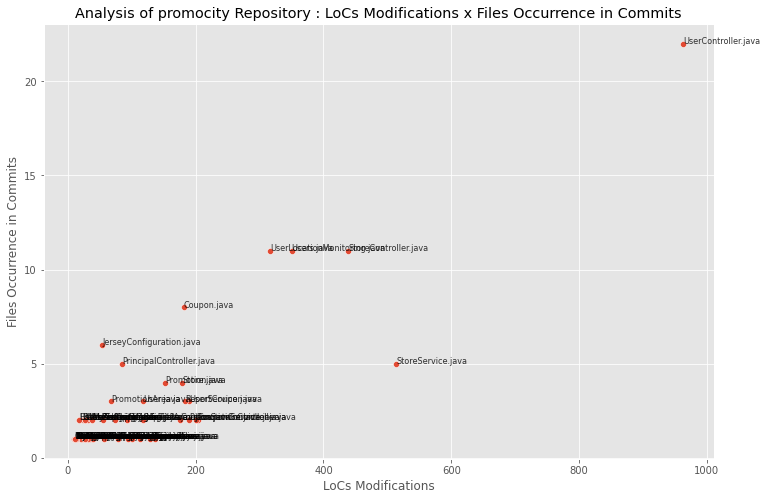

In [50]:
generate_sccater_plot(df_fc_ml, repositorio1)

### SysPromocity

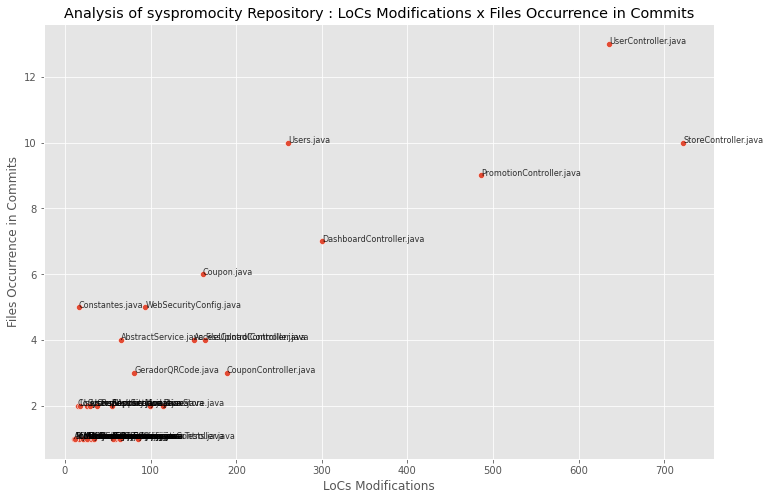

In [51]:
generate_sccater_plot(df_fc_ml_2, repositorio2)

In [ ]:
generate_sccater_plot_2(df_fc_ml, repositorio1)

In [ ]:
generate_sccater_plot_2(df_fc_ml_2, repositorio2)

## Distribuição de Quartis para Frequência de Commits

### Promocity

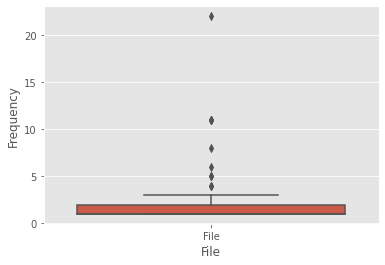

In [54]:
df_boxplot_fc = generate_box_plot_frequency(df_fc_ml)

In [55]:
fc_q1, fc_q2, fc_q3, fc_q4 = get_quartiles_frequency(df_boxplot_fc)
print(f'Quartis da Frequencia de Commits Q1: {fc_q1}, Q2: {fc_q2}, Q3: {fc_q3}, Q4: {fc_q4}')

Quartis da Frequencia de Commits Q1: [1.], Q2: [1.], Q3: [2.], Q4: [22.]


### SysPromocity

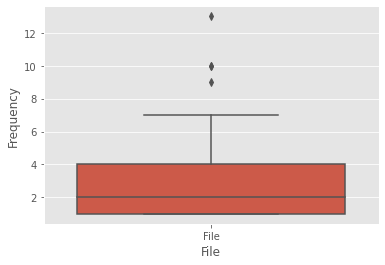

In [56]:
df_boxplot_fc_2 = generate_box_plot_frequency(df_fc_ml_2)

In [57]:
fc_q1_2, fc_q2_2, fc_q3_2, fc_q4_2 = get_quartiles_frequency(df_boxplot_fc_2)
print(f'Quartis da Frequencia de Commits Q1: {fc_q1_2}, Q2: {fc_q2_2}, Q3: {fc_q3_2}, Q4: {fc_q4_2}')

Quartis da Frequencia de Commits Q1: [1.], Q2: [2.], Q3: [4.], Q4: [13.]


## Distribuição de Quartis para Linhas Modificadas ao longo do tempo

### Promocity

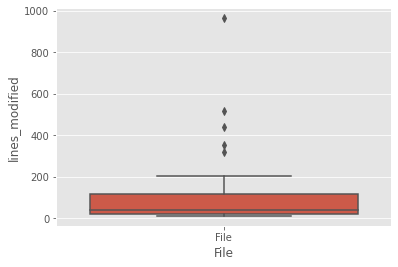

In [58]:
df_boxplot_lm = generate_box_plot_lines_modified(df_fc_ml)

In [59]:
lm_q1, lm_q2, lm_q3, lm_q4 = get_quartiles_lines_modified(df_boxplot_lm)
print(f'Quartis da Linhas Modificadas Q1: {lm_q1}, Q2: {lm_q2}, Q3: {lm_q3}, Q4: {lm_q4}')

Quartis da Linhas Modificadas Q1: [20.], Q2: [37.], Q3: [118.], Q4: [963.]


### SysPromocity

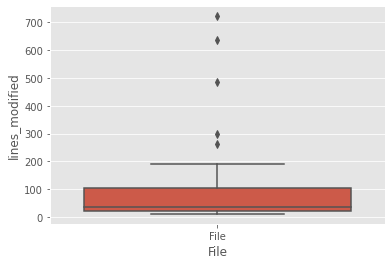

In [60]:
df_boxplot_lm_2 = generate_box_plot_lines_modified(df_fc_ml_2)

In [61]:
lm_q1_2, lm_q2_2, lm_q3_2, lm_q4_2 = get_quartiles_lines_modified(df_boxplot_lm_2)
print(f'Quartis da Linhas Modificadas Q1: {lm_q1_2}, Q2: {lm_q2_2}, Q3: {lm_q3_2}, Q4: {lm_q4_2}')

Quartis da Linhas Modificadas Q1: [22.5], Q2: [35.5], Q3: [103.], Q4: [722.]


## Resultados das Análises do Promocity

In [62]:
# Lista os arquivos com maior frequência de commits e mais linhas modificadas ao longo do tempo
df_fc_ml.query("Frequency > 2 and lines_modified > 118")

,File,Frequency,lines_modified
3,UserLocationMonitoring.java,11,316
5,StoreController.java,11,439
6,UserController.java,22,963
9,Coupon.java,8,181
10,Promotion.java,4,152
11,Store.java,4,179
16,StoreService.java,5,514
17,UserService.java,3,190
34,Users.java,11,350
45,ReportCoupon.java,3,183


In [ ]:
df_arquivos_criticos = df_fc_ml.query("Frequency > 2 and lines_modified > 118")

qtd_arquivos_criticos = df_arquivos_criticos.shape[0]
qtd_arquivos_java = df_fc_ml.shape[0]

print(f'Qtd arquivos críticos: {qtd_arquivos_criticos}, Total de Arquivos .java {qtd_arquivos_java}')
print(f'{round(qtd_arquivos_criticos/qtd_arquivos_java, 2)*100}% dos arquivos .java são críticos')

total_linhas_modificadas = sum(df_fc_ml['lines_modified'])
linhas_modificadas_arquivos_criticos = sum(df_arquivos_criticos['lines_modified'])

print(f'Qtd de linhas modificadas pelos arquivos críticos: {linhas_modificadas_arquivos_criticos}, Total de linhas de código alteradas ao longo do tempo: {total_linhas_modificadas}')
print(f'{round(linhas_modificadas_arquivos_criticos/total_linhas_modificadas, 2)*100}% do esforço de modificação é com arquivos críticos')

## Resultados das Análises do SysPromocity

In [63]:
# Lista os arquivos com maior frequência de commits e mais linhas modificadas ao longo do tempo
df_fc_ml_2.query("Frequency > 4 and lines_modified > 103")

,File,Frequency,lines_modified
5,DashboardController.java,7,300
6,PromotionController.java,9,486
7,StoreController.java,10,722
8,UserController.java,13,636
10,Coupon.java,6,161
14,Users.java,10,261


In [65]:
df_arquivos_criticos_2 = df_fc_ml_2.query("Frequency > 4 and lines_modified > 103")

qtd_arquivos_criticos_2 = df_arquivos_criticos_2.shape[0]
qtd_arquivos_java_2 = df_fc_ml_2.shape[0]

print(f'Qtd arquivos críticos: {qtd_arquivos_criticos_2}, Total de Arquivos .java {qtd_arquivos_java_2}')
print(f'{round(qtd_arquivos_criticos_2/qtd_arquivos_java_2, 2)*100}% dos arquivos .java são críticos')

total_linhas_modificadas_2 = sum(df_fc_ml_2['lines_modified'])
linhas_modificadas_arquivos_criticos_2 = sum(df_arquivos_criticos_2['lines_modified'])

print(f'Qtd de linhas modificadas pelos arquivos críticos: {linhas_modificadas_arquivos_criticos_2}, Total de linhas de código alteradas ao longo do tempo: {total_linhas_modificadas_2}')
print(f'{round(linhas_modificadas_arquivos_criticos_2/total_linhas_modificadas_2, 2)*100}% do esforço de modificação é com arquivos críticos')

Qtd arquivos críticos: 6, Total de Arquivos .java 40
15.0% dos arquivos .java são críticos
Qtd de linhas modificadas pelos arquivos críticos: 2566, Total de linhas de código alteradas ao longo do tempo: 4313
59.0% do esforço de modificação é com arquivos críticos
